# Load graph

In [1]:
# !pip install  dgl -f https://data.dgl.ai/wheels/cu121/repo.html
import networkx as nx
import pandas as pd
import json
import dgl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import utils

graph, _, labels_data, features_data = utils.load_graph()

g, train_mask, val_mask, test_mask = utils.get_mask(graph)

labels, num_classes = utils.get_labels(labels_data)

# Multinominal Node Classification

### preprocessing: masks, labels, features

In [2]:
naive_feat = utils.get_naive_feat(graph)
property_feat = utils.get_property_feat(graph)
feat = utils.get_real_feat(graph, features_data)

feat.shape

torch.Size([7624, 7842])

### build the GNN and training function

In [3]:
from dgl.nn import SAGEConv

class GNN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GNN, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, "mean")
        self.conv2 = SAGEConv(h_feats, h_feats, "mean")
        self.linear = nn.Linear(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        embeddings = h
        h = self.linear(h)
        return h, embeddings

In [4]:
def train(g,model,features, epochs=100, learning_rate=0.01, early_stopping_rounds=3):
    optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_val_acc = 0
    best_test_acc = 0
    best_embeddings = []

    statistic = {
        'loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
    }
    
    early_stopping_counter = 0
    best_val_loss = float('inf')

    for e in range(epochs):
        # Forward
        logits, embeddings = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])
        
        # Compute loss on validation set
        val_loss = F.cross_entropy(logits[val_mask], labels[val_mask])

        #Compute accuracy on training/validation
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        

        # Save loss , val_acc and test_acc
        statistic['loss'].append(loss)
        statistic['val_loss'].append(val_loss)
        statistic['train_acc'].append(train_acc)
        statistic['val_acc'].append(val_acc)

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
            best_embeddings = embeddings

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % (epochs // 10) == 0:
            print(f"In epoch {e}, loss: {loss:.3f}, val acc: {val_acc:.3f} (best {best_val_acc:.3f}, best {best_test_acc:.3f})")

            # Check for early stopping
            if early_stopping_rounds != 0:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= early_stopping_rounds:
                        print(f"Early stopping at epoch {e}")
                        break

    return best_val_acc, best_test_acc, best_embeddings, statistic

### train the models

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device is :', device)

hidden_dim = 16
epochs = 500

print(torch.version.cuda)
print(torch.__version__)
g = g.to(device)
labels = labels.to(device)

device is : cuda
12.1
2.1.2


In [6]:
import matplotlib.pyplot as plt

def train_model(ModelClass, feat, hidden_dim, num_classes, graph, epochs, learning_rate, early_stopping_rounds):
    model = ModelClass(feat.shape[1], hidden_dim, num_classes).to(device)
    feat = feat.to(device)
    best_val_acc, best_test_acc, best_embeddings, info = train(graph, model, feat, epochs, learning_rate, early_stopping_rounds)
    return best_val_acc, best_test_acc, best_embeddings, info


def plot_statistics(statistics):
  # plot the loss

  loss_values = [loss.item() for loss in statistics['loss']]
  val_loss_values = [loss.item() for loss in statistics['val_loss']]

  plt.figure()
  plt.plot(loss_values, label='train loss')
  plt.plot(val_loss_values, label='val loss')
  
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

  # plot validation accuracy and test accuracy in the same figure

  train_values = [acc.item() for acc in statistics['train_acc']]
  val_values = [acc.item() for acc in statistics['val_acc']]

  plt.figure()
  plt.plot(train_values, label='train acc')
  plt.plot(val_values, label='val acc')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

def train_wrapper(ModelClass, feat, hidden_dim, num_classes, graph, epochs=100, learning_rate=0.01, early_stopping_rounds=3):
    best_val_acc, best_test_acc, best_embeddings, info = train_model(ModelClass, feat, hidden_dim, num_classes, graph, epochs, learning_rate, early_stopping_rounds)
    plot_statistics(info)
    print(f"Best val acc: {best_val_acc:.3f}, best test acc: {best_test_acc:.3f}")
    return best_embeddings


###

In [7]:
class GNNrepeat(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes, repeat_time):
        super(GNNrepeat, self).__init__()
        self.repeat_time = repeat_time
        
        self.conv1 = SAGEConv(in_feats, h_feats, "mean")
        self.conv2 = SAGEConv(h_feats, h_feats, "mean")
        self.linear = nn.Linear(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        for i in range(self.repeat_time-2):
            h = self.conv2(g, h)
            h = F.relu(h)
        h = self.conv2(g, h)
        embeddings = h
        h = self.linear(h)
        return h, embeddings

class GNN5(GNNrepeat):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GNN5, self).__init__(in_feats, h_feats, num_classes, 5)

class GNN10(GNNrepeat):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GNN10, self).__init__(in_feats, h_feats, num_classes, 10)
        
class GNN15(GNNrepeat):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GNN15, self).__init__(in_feats, h_feats, num_classes, 15)

### Transductive vs Inductive

#### seperate subgraphs and redefine training function

In [8]:
train_graph = dgl.node_subgraph(g, torch.tensor(train_mask))
val_graph = dgl.node_subgraph(g, torch.tensor(val_mask))
test_graph = dgl.node_subgraph(g, torch.tensor(test_mask))

In [9]:
# seperately train 3 graphs.
def train_in(train_graph, val_graph, test_graph, model, feat, epochs=100, learning_rate=0.01, early_stopping_rounds=3):
    optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_val_acc = 0
    best_test_acc = 0
    best_train_embeddings = []
    best_val_embeddings = []
    best_test_embeddings = []
    
    statistics = {
        'loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
    }
    
    early_stopping_counter = 0
    best_val_loss = float('inf')

    for e in range(epochs):
        # Forward
        train_logits, train_embeddings = model(train_graph, feat[train_mask])
        val_logits, val_embeddings = model(val_graph, feat[val_mask])

        # Compute prediction
        train_pred = train_logits.argmax(1)
        val_pred = val_logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(train_logits, labels[train_mask])
        
        # Compute loss on validation set
        val_loss = F.cross_entropy(val_logits, labels[val_mask])

        #Compute accuracy on training/validation/test
        train_acc = (train_pred == labels[train_mask]).float().mean()
        val_acc = (val_pred == labels[val_mask]).float().mean()
        
        
        statistics['loss'].append(loss)
        statistics['val_loss'].append(val_loss)
        statistics['train_acc'].append(train_acc)
        statistics['val_acc'].append(val_acc)

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc

            test_logits, test_embeddings = model(test_graph, feat[test_mask])
            test_pred = test_logits.argmax(1)
            best_test_acc = (test_pred == labels[test_mask]).float().mean()

            best_train_embeddings = train_embeddings
            best_val_embeddings = val_embeddings
            best_test_embeddings = test_embeddings

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % (epochs // 10) == 0:
            print(f"In epoch {e}, loss: {loss:.3f}, val acc: {val_acc:.3f} (best {best_val_acc:.3f}, best {best_test_acc:.3f})")
            
            # early stopping
            if early_stopping_rounds != 0:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= early_stopping_rounds:
                        print(f"Early stopping at epoch {e}")
                        break

    return best_val_acc, best_test_acc, best_train_embeddings, best_val_embeddings, best_test_embeddings, statistics

#### train model

In [10]:
def train_in_wrapper(ModelClass, feat, hidden_dim, num_classes, train_graph, val_graph, test_graph, epochs=100, learning_rate=0.01, early_stopping_rounds=3):
    in_model = ModelClass(feat.shape[1], hidden_dim, num_classes).to(device)
    feat = feat.to(device)
    best_val_acc, best_test_acc, best_train_embeddings, best_val_embeddings, best_test_embeddings, info = train_in(train_graph, val_graph, test_graph, in_model, feat, epochs, learning_rate, early_stopping_rounds)
    plot_statistics(info)
    print(f"Best val acc: {best_val_acc:.3f}, best test acc: {best_test_acc:.3f}")
    
    best_embeddings = {
        'train': best_train_embeddings,
        'val': best_val_embeddings,
        'test': best_test_embeddings
    }
    
    return best_embeddings


In epoch 0, loss: 2.987, val acc: 0.088 (best 0.088, best 0.090)
In epoch 50, loss: 0.412, val acc: 0.673 (best 0.673, best 0.662)
In epoch 100, loss: 0.143, val acc: 0.717 (best 0.717, best 0.700)
In epoch 150, loss: 0.081, val acc: 0.719 (best 0.719, best 0.710)
In epoch 200, loss: 0.058, val acc: 0.717 (best 0.721, best 0.710)
In epoch 250, loss: 0.046, val acc: 0.723 (best 0.723, best 0.718)
Early stopping at epoch 250


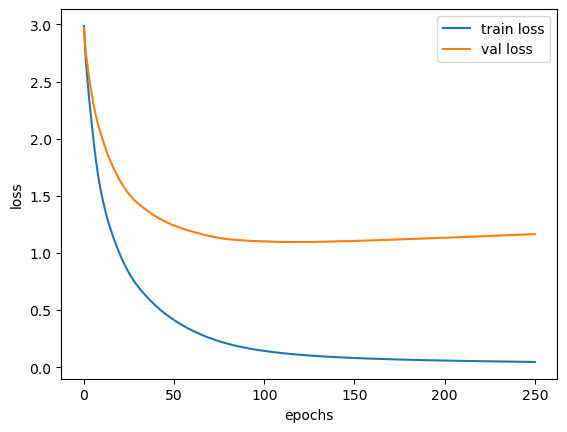

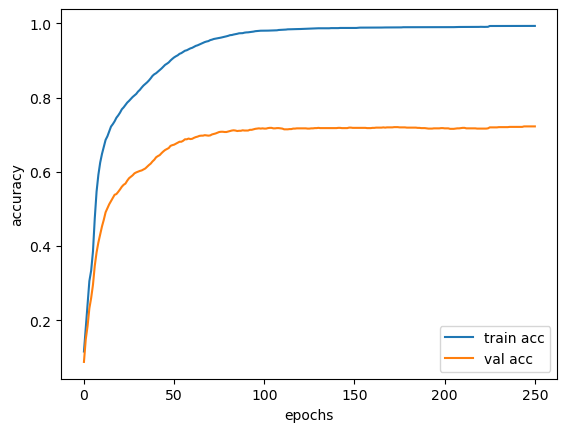

Best val acc: 0.723, best test acc: 0.718


In [11]:

GNN_in_embeddings = train_in_wrapper(GNN, feat, hidden_dim, num_classes,train_graph, val_graph, test_graph, epochs=500, learning_rate=1e-3)

#### change layer: 5

In epoch 0, loss: 4.335, val acc: 0.039 (best 0.039, best 0.031)
In epoch 50, loss: 2.409, val acc: 0.154 (best 0.154, best 0.148)
In epoch 100, loss: 2.073, val acc: 0.185 (best 0.185, best 0.174)
In epoch 150, loss: 1.728, val acc: 0.260 (best 0.260, best 0.249)
In epoch 200, loss: 1.212, val acc: 0.441 (best 0.441, best 0.439)
In epoch 250, loss: 0.759, val acc: 0.466 (best 0.466, best 0.482)
In epoch 300, loss: 0.474, val acc: 0.494 (best 0.496, best 0.506)
In epoch 350, loss: 0.316, val acc: 0.503 (best 0.503, best 0.511)
Early stopping at epoch 350


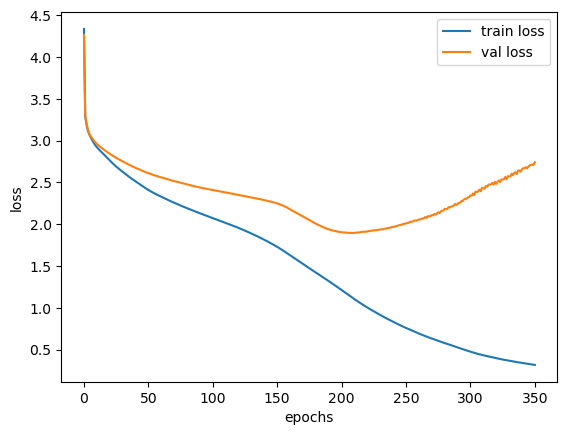

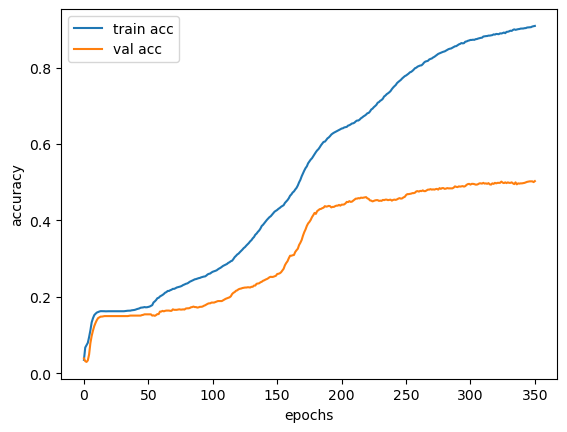

Best val acc: 0.503, best test acc: 0.511


In [12]:

GNN5_in_embeddings = train_in_wrapper(GNN5, feat, hidden_dim, num_classes,train_graph, val_graph, test_graph, epochs=500, learning_rate=1e-3)

#### layer = 10

In epoch 0, loss: 2.904, val acc: 0.065 (best 0.065, best 0.071)
In epoch 40, loss: 1.428, val acc: 0.380 (best 0.380, best 0.404)
In epoch 80, loss: 1.028, val acc: 0.427 (best 0.431, best 0.443)
In epoch 120, loss: 0.783, val acc: 0.447 (best 0.449, best 0.450)
In epoch 160, loss: 0.627, val acc: 0.477 (best 0.477, best 0.485)
In epoch 200, loss: 0.498, val acc: 0.490 (best 0.494, best 0.506)
In epoch 240, loss: 0.412, val acc: 0.483 (best 0.494, best 0.506)
Early stopping at epoch 240


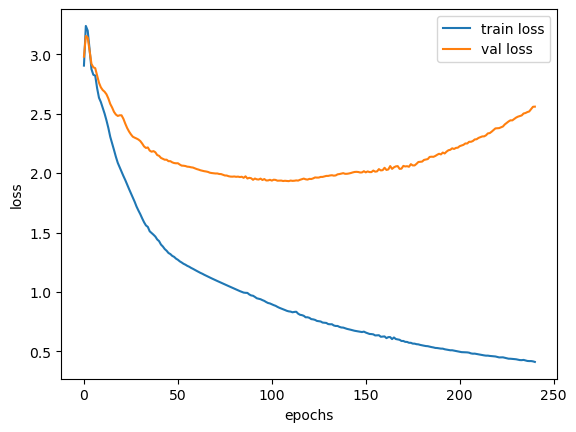

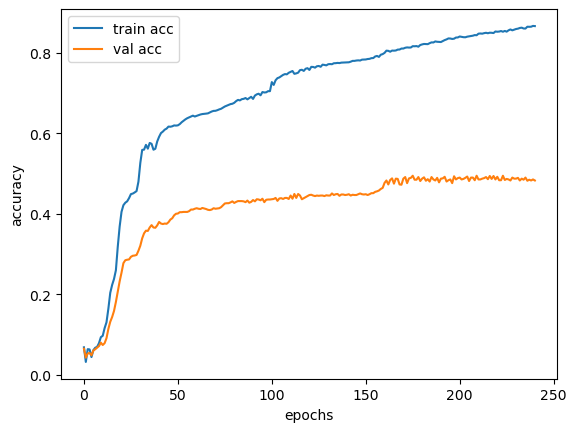

Best val acc: 0.494, best test acc: 0.506


In [33]:
GNN10_in_embeddings = train_in_wrapper(GNN10, feat, hidden_dim, num_classes,train_graph, val_graph, test_graph, epochs=400, learning_rate=1e-3)

## visualize the embedding features

In [36]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_embeddings_in(in_embeddings, labels, train_mask, val_mask, test_mask):
  train_embedding = in_embeddings['train'].cpu().detach().numpy()
  train_tsne = TSNE().fit_transform(train_embedding)
  val_embedding = in_embeddings['val'].cpu().detach().numpy()
  val_tsne = TSNE().fit_transform(val_embedding)
  test_embedding = in_embeddings['test'].cpu().detach().numpy()
  test_tsne = TSNE().fit_transform(test_embedding)

  train_labels = labels[train_mask].cpu().numpy()
  val_labels = labels[val_mask].cpu().numpy()
  test_labels = labels[test_mask].cpu().numpy()
  
  fig, axes = plt.subplots(nrows=1, ncols=3)
  axes[0].scatter(train_tsne[:, 0], train_tsne[:, 1], c=train_labels)
  axes[1].scatter(val_tsne[:, 0], val_tsne[:, 1], c=val_labels)
  axes[2].scatter(test_tsne[:, 0], test_tsne[:, 1], c=test_labels)
  plt.show()

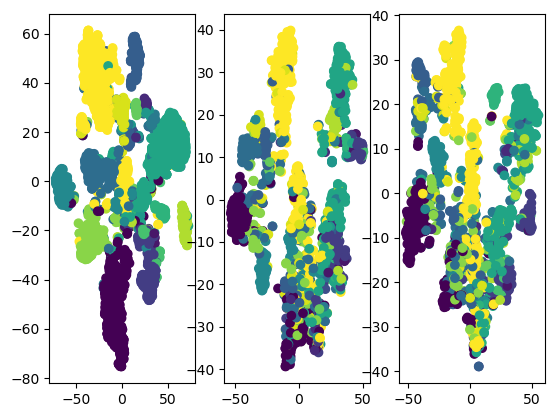

In [39]:
plot_embeddings_in(GNN_in_embeddings, labels, train_mask, val_mask, test_mask)

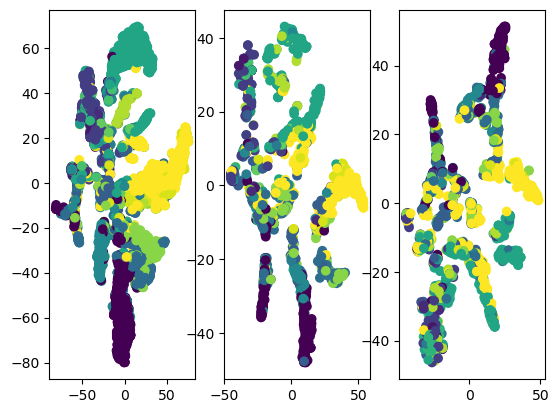

In [37]:
plot_embeddings_in(GNN5_in_embeddings, labels, train_mask, val_mask, test_mask)

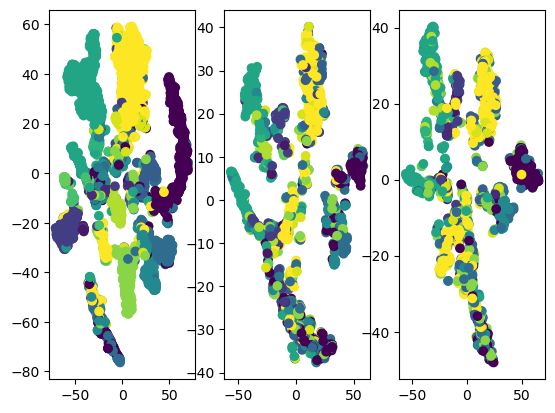

In [38]:
plot_embeddings_in(GNN10_in_embeddings, labels, train_mask, val_mask, test_mask)